In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import surprise as sp
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV, RandomizedSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm, tqdm_notebook
import os

## Comparativa Metodos KNN y Busqueda de hiperParametros

In [34]:
df_train = pd.read_csv('./data/ratings_train.csv')
df_test = pd.read_csv('./data/ratings_test.csv')

In [35]:
trainset, testset = train_test_split(df_train, test_size=0.30)
#trainset = df_train
#testset = df_test
print(trainset.shape, testset.shape)

(539062, 10) (231027, 10)


In [3]:
df_train_s = df_train[:10000]
train, test = train_test_split(df_train_s, test_size=0.30)
reader = sp.reader.Reader(rating_scale=(0.5, 5))
data= sp.dataset.Dataset.load_from_df(train[['userID', 'movieID', 'rating']], reader)


# opciones del algoritmo
sim_options = {
    'name': 'pearson_baseline', # Podria ser "cosine" o "MSD", "pearson", "pearson_baseline"
    'user_based': False, #False,   # TRUE basado en Usuarios (compara usuarios con usuarios), False basado en Items. (Hay que probar)
    #'shrinkage': 1  # no shrinkage
}


KNNBasic_algo = sp.prediction_algorithms.knns.KNNBasic(k=40, min_k=5, sim_options=sim_options)
KNNWithMeans_algo = sp.prediction_algorithms.knns.KNNWithMeans(k=40, min_k=5, sim_options=sim_options)
KNNWithZScore_algo = sp.prediction_algorithms.knns.KNNWithZScore(k=40, min_k=5, sim_options=sim_options)


KNNBasic_cv = sp.model_selection.validation.cross_validate(KNNBasic_algo, data, measures=['rmse', 'mae'], cv=5, n_jobs=-1)
KNNWithMeans_cv = sp.model_selection.validation.cross_validate(KNNWithMeans_algo, data, measures=['rmse', 'mae'], cv=5, n_jobs=-1)
KNNWithZScore_cv = sp.model_selection.validation.cross_validate(KNNWithZScore_algo, data, measures=['rmse', 'mae'], cv=5, n_jobs=-1)

print('Algorithm\t RMSE\t\t MAE')
print()
print('KNN Basic', '\t', round(KNNBasic_cv['test_rmse'].mean(), 4), '\t', round(KNNBasic_cv['test_mae'].mean(), 4))
print('KNN Means', '\t', round(KNNWithMeans_cv['test_rmse'].mean(), 4), '\t', round(KNNWithMeans_cv['test_mae'].mean(), 4))
print('KNN ZScore', '\t', round(KNNWithZScore_cv['test_rmse'].mean(), 4), '\t', round(KNNWithZScore_cv['test_mae'].mean(), 4))
print()

Algorithm	 RMSE		 MAE

KNN Basic 	 1.0348 	 0.8327
KNN Means 	 1.0381 	 0.809
KNN ZScore 	 1.0427 	 0.8156



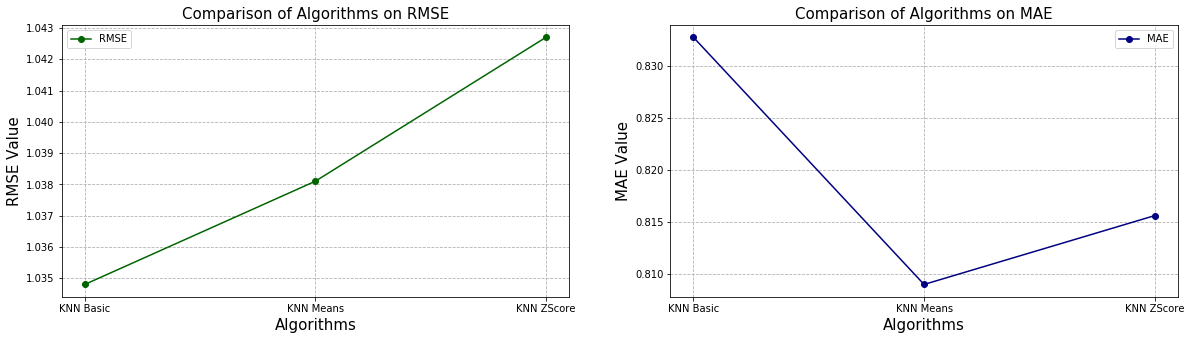

In [4]:
x_algo = ['KNN Basic', 'KNN Means', 'KNN ZScore']
all_algos_cv = [KNNBasic_cv, KNNWithMeans_cv, KNNWithZScore_cv]

rmse_cv = [round(res['test_rmse'].mean(), 4) for res in all_algos_cv]
mae_cv = [round(res['test_mae'].mean(), 4) for res in all_algos_cv]

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=15)
plt.plot(x_algo, rmse_cv, label='RMSE', color='darkgreen', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.subplot(1, 2, 2)
plt.title('Comparison of Algorithms on MAE', loc='center', fontsize=15)
plt.plot(x_algo, mae_cv, label='MAE', color='navy', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()

### Mejor resultado el KNN Basic si tomo el RMSE.

## Busqueda de hiper parametros

In [23]:
df_train_s = df_train[:20000] #770089
reader = sp.reader.Reader(rating_scale=(0.5, 5))
data_train= sp.dataset.Dataset.load_from_df(df_train_s[['userID', 'movieID', 'rating']], reader)
print(len(df_train_s))

20000


In [24]:
param_grid =  {'min_k': [2, 3, 4, 5, 6, 7, 8], 'k': [10, 15, 20, 25, 30, 35, 40, 45, 50],
                'sim_options': {'name': ["msd", "cosine", "pearson_baseline", "pearson"],
                #'sim_options': {'name': ["pearson_baseline"],
                              'min_support': [1, 5],
                              'user_based': [False, True]}}

#knnbasic_gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)
#knnbasic_gs.fit(data_train)
#knnmeans_gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)
#knnmeans_gs.fit(data)
#knnz_gs = GridSearchCV(KNNWithZScore, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)
#knnz_gs.fit(data)

In [25]:
knnbasic_gs = RandomizedSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'],n_iter=10, n_jobs=-1)
knnbasic_gs.fit(data_train)
print("KNNBasic")
print('RMSE =', knnbasic_gs.best_params['rmse']) #, 'MAE =', knnbasic_gs.best_params['mae'])

KNNBasic
RMSE = {'min_k': 6, 'k': 45, 'sim_options': {'name': 'msd', 'min_support': 1, 'user_based': False}}


In [26]:
knnmeans_gs = RandomizedSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], n_iter=10, n_jobs=-1)
knnmeans_gs.fit(data_train)
print("KNNWithMeans")
print('RMSE =', knnmeans_gs.best_params['rmse']) #, 'MAE =', knnbasic_gs.best_params['mae'])

KNNWithMeans
RMSE = {'min_k': 3, 'k': 25, 'sim_options': {'name': 'msd', 'min_support': 5, 'user_based': True}}


In [27]:
knnz_gs     = RandomizedSearchCV(KNNWithZScore, param_grid, measures=['rmse', 'mae'], n_iter=10, n_jobs=-1)
knnz_gs.fit(data_train)
print("KNNWithZScore")
print('RMSE =', knnz_gs.best_params['rmse']) #, 'MAE =', knnbasic_gs.best_params['mae'])

KNNWithZScore
RMSE = {'min_k': 5, 'k': 25, 'sim_options': {'name': 'msd', 'min_support': 5, 'user_based': True}}


## KNN

In [ ]:
param_grid =  {'min_k': [2, 3, 4, 5, 6, 7, 8], 'k': [10, 15, 20, 25, 30, 35, 40, 45, 50],
                'sim_options': {'name': ["msd", "cosine", "pearson_baseline", "pearson"],
                #'sim_options': {'name': ["pearson_baseline"],
                              'min_support': [1, 5],
                              'user_based': [False, True]}}

#knnbasic_gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)
#knnbasic_gs.fit(data_train)

In [15]:
x = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
y1 = knnbasic_gs.cv_results['mean_test_rmse']
y2 = knnbasic_gs.cv_results['mean_test_mae']

y3 = knnmeans_gs.cv_results['mean_test_rmse']
y4 = knnmeans_gs.cv_results['mean_test_mae']

y5 = knnz_gs.cv_results['mean_test_rmse']
y6 = knnz_gs.cv_results['mean_test_mae']

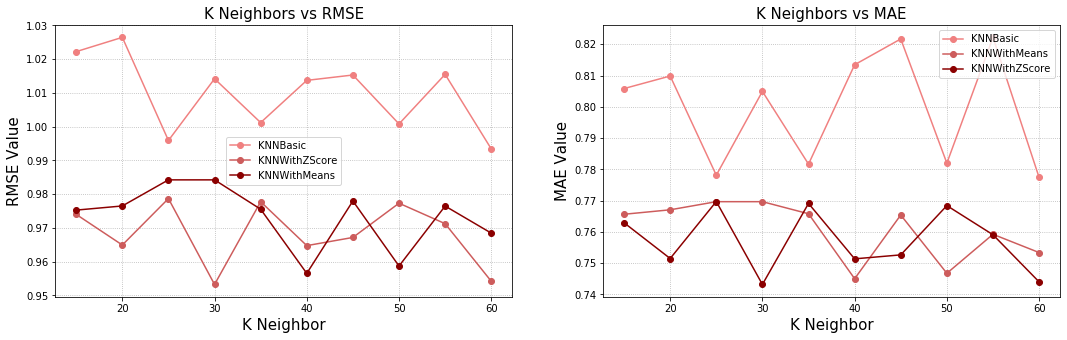

In [16]:
plt.figure(figsize=(18,5))

plt.subplot(1, 2, 1)
plt.title('K Neighbors vs RMSE', loc='center', fontsize=15)
plt.plot(x, y1, label='KNNBasic', color='lightcoral', marker='o')
plt.plot(x, y5, label='KNNWithZScore', color='indianred', marker='o')
plt.plot(x, y3, label='KNNWithMeans', color='darkred', marker='o')
plt.xlabel('K Neighbor', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dotted')

plt.subplot(1, 2, 2)
plt.title('K Neighbors vs MAE', loc='center', fontsize=15)
plt.plot(x, y2, label='KNNBasic', color='lightcoral', marker='o')
plt.plot(x, y4, label='KNNWithMeans', color='indianred', marker='o')
plt.plot(x, y6, label='KNNWithZScore', color='darkred', marker='o')
plt.xlabel('K Neighbor', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dotted')

plt.show()

## Generar Prediccion

In [36]:
data= sp.dataset.Dataset.load_from_df(trainset[['userID', 'movieID', 'rating']], reader)

sim_options = {
    'name': 'msd', 
    'user_based': True, 
    'min_support': 5,
}

KNNWithMeans_algo = sp.prediction_algorithms.knns.KNNWithMeans(k=25, min_k=3, sim_options=sim_options)

In [37]:
trainset = data.build_full_trainset()
pred_KNNBasic = KNNBasic_algo.fit(trainset)
pred_KNNWithMeans = KNNWithMeans_algo.fit(trainset)
pred_KNNWithZScore = KNNWithZScore_algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [38]:
def full_prediction(algo_name,algoritmo,test):
    list_pred = []
    for index, row in tqdm_notebook(test.iterrows()):
        row_pred = dict()
        uid = row.userID
        iid = row.movieID
        pred = algoritmo.predict(uid, iid, verbose=False)
        row_pred["ID"] = row.ID.astype(int)
        row_pred["rating"] = np.around(pred.est, 2)
        list_pred.append(row_pred)
    df = pd.DataFrame(list_pred)    
    #return df
    print(algo_name + " MSE:      %.4f" % mean_squared_error(test.rating, df.rating))

In [40]:
full_prediction("KNNBasic",KNNBasic_algo,testset)
full_prediction("KNNWithMeans",KNNWithMeans_algo,testset)
full_prediction("KNNWithZScore",KNNWithZScore_algo,testset)


KNNBasic MSE:      0.7017



KNNWithMeans MSE:      0.6664



KNNWithZScore MSE:      0.6052
